# Read data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from scipy import interpolate
import random
import re

%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [2]:
obj_library = {}
with open("imagenet1000_clsidx_to_labels.txt") as f:
    obj_library = json.load(f)


In [9]:
def find_obj_in_text(obj_names,text):

    obj = ""
    for w in re.split("\s|(?<!\d)[,.](?!\d)",text):
        if w in obj_names:
            obj = w
    return obj
def change_obj_names(obj_names,text):
    new_objs_class = random.sample(obj_library.keys(),len(obj_names))
    new_objs = [random.choice(obj_library[o]) for o in new_objs_class]

    obj = find_obj_in_text(obj_names,text)
    if obj != "":
        new_obj = new_objs[obj_names.index(obj)]
        text = text.replace(obj,new_obj)
        obj = new_obj
    return new_objs, obj, text

def load_data(data_dir = "../data/train2", change_names =False):
    
    json_files = [pos_json for pos_json in os.listdir(data_dir) if pos_json.endswith('.json')]
    data = []
    for index, js in enumerate(json_files):
        with open(os.path.join(data_dir, js)) as json_file:
            json_text = json.load(json_file)

            #TODO: change text extraction
            text = js.split("_", 1)[1][:-8] 

            #TODO: change in the normalization
            objs_x = np.array(json_text["meta"]["o_center_x"])/json_text["meta"]["width"]
            objs_y = np.array(json_text["meta"]["o_center_y"])/json_text["meta"]["height"]


            #replace objs for random ones, avoids repetive obj names
            obj_names = json_text["meta"]["obj_names"]
            obj = ""

            if change_names:
                new_objs, obj, text = change_obj_names(obj_names,text)
            else:
                new_objs = obj_names
                obj = find_obj_in_text(obj_names,text)

            
            #TODO: add radius
            data.append({"input_traj":json_text["input_traj"],
                        "output_traj":json_text["output_traj"],
                        "text":text,
                        "obj_names":new_objs,
                        "obj_poses":np.stack([objs_x,objs_y],axis = 0),
                        "obj_in_text":obj
                        })
            # print(data)
            # break

    return data
data = load_data(data_dir = "../data/train")+ load_data(data_dir = "../data/train2/train2")


In [12]:


# def rotate(origin, points , angle):
#     """ Rotate a point counterclockwise by a given angle (rad) around a given origin.    """

#     ox, oy = origin
#     qx = ox + np.cos(angle) * (px - ox) - np.sin(angle) * (py - oy)
#     qy = oy + np.sin(angle) * (px - ox) + np.cos(angle) * (py - oy)
#     return qx, qy
    
# def rotate_via_numpy(xy, origin,radians):
#     """Use numpy to build a rotation matrix and take the dot product."""
#     c, s = np.cos(radians), np.sin(radians)
#     R = np.array(((c, -s), (s, c)))
#     m = origin + np.dot(xy-origin,R)

#     return m

# p = np.array([[0,0],[1,0],[1,1],[0,1]])
# o = [0.5,0.5]
# print(rotate_via_numpy(p,o,np.pi/2))

# # def rotate_data(d, rot_list, traj_n=10):
# #     """generates rotations of the dataset"""
# #     rotations = []
# #     for r in rot_list:
# #         d_new = d.copy()
# #         d_new["input_traj"] = rotate((0.5,0.5),d_new["input_traj"][:traj_n],d_new["input_traj"][traj_n:] ) 
# #         rotations.append(d_new)
# #     return rotations

# show_data(X[:3])
# # show_data(rotate_data(data[0],[np.pi/2,np.pi]))

# # rotate_data(X)

# Model
## Text embeding

In [ ]:
# import tensorflow_hub as hub
# import tokenization
# module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
# bert_layer = hub.KerasLayer(module_url, trainable=False)

In [ ]:
# vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
# do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
# tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

# def bert_encode(texts, tokenizer, max_len=512):
#     all_tokens = []
#     all_masks = []
#     all_segments = []
    
#     for text in texts:
#         text = tokenizer.tokenize(text)
            
#         text = text[:max_len-2]
#         input_sequence = ["[CLS]"] + text + ["[SEP]"]
#         pad_len = max_len - len(input_sequence)
        
#         tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
#         pad_masks = [1] * len(input_sequence) + [0] * pad_len
#         segment_ids = [0] * max_len
        
#         all_tokens.append(tokens)
#         all_masks.append(pad_masks)
#         all_segments.append(segment_ids)
    
#     return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [2]:
from sklearn.model_selection import train_test_split
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')


import clip
import matplotlib.pyplot as plt

In [3]:


class Motion_refiner():
    def __init__(self, traj_n = 10,verbose=0):
        """
        traj_n: num of waypoints for the interpolated trajectory
        verbose: 0 = none, 1 = prints
        """
        # super().__init__()
        self.traj_n = traj_n
        self.verbose = verbose
        self.BERT_token_len = 19
        self.BERT_model, self.BERT_tokenizer = self.load_bert()
        self.CLIP_model, self.CLIP_tokenizer = self.load_CLIP()

    def load_bert(self,verbose = 0):
        """load a pre-trained BERT model (DistilBERT)"""

        # For DistilBERT:
        model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

        # Load pretrained model/tokenizer
        tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
        model = model_class.from_pretrained(pretrained_weights) 
        if self.verbose > 0: print(" ----- BERT model loaded -----")

        return model, tokenizer     
    def load_CLIP(self, verbose = 0):
        model, preprocess = clip.load("ViT-B/32")
        model.cuda().eval()
        input_resolution = model.visual.input_resolution
        context_length = model.context_length
        vocab_size = model.vocab_size
        
        if self.verbose > 0:
            print(" ---- CLIP model loaded ----- ")
            print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
            print("Input resolution:", input_resolution)
            print("Context length:", context_length)
            print("Vocab size:", vocab_size)

        return model, preprocess

    def compute_clip_similarity(self, obj_names, text):
        """computes the similarity vector between the embeded representation of a list of objects and a list of texts"""

        token_obj_name = clip.tokenize([o for o in obj_names]).cuda()
        token_clip_text = clip.tokenize(text).cuda()

        with torch.no_grad():
            obj_names_features = self.CLIP_model.encode_text(token_obj_name).float()
            text_clip_features = self.CLIP_model.encode_text(token_clip_text).float()

        obj_names_features /= obj_names_features.norm(dim=-1, keepdim=True)
        text_clip_features /= text_clip_features.norm(dim=-1, keepdim=True)
        similarity = text_clip_features.cpu().numpy() @ obj_names_features.cpu().numpy().T

        return token_obj_name, token_clip_text, similarity

    def compute_bert_embeding(self,data):

        for d in data:
            d["token_text"] = self.BERT_tokenizer.encode(d["text"])
            if len(d["token_text"]) > self.BERT_token_len:
                self.BERT_token_len = len(d["token_text"])
                
        padded_texts = np.array([d["token_text"] + [0]*(self.BERT_token_len-len(d["token_text"] )) for d in data])
        attention_mask = np.where(padded_texts != 0, 1, 0) #to ignore the pad values

        input_ids = torch.tensor(padded_texts)  
        attention_mask = torch.tensor(attention_mask)
        # print(input_ids.shape)

        with torch.no_grad():
            last_hidden_states = self.BERT_model(input_ids, attention_mask=attention_mask)

        text_features = last_hidden_states[0][:,0,:].numpy() #embbeded by BERT
        # print(text_features.shape)
        
        return text_features

    def interpolate_traj(self, traj):
        # interpolates the traj
        tck_i,u_i=interpolate.splprep(traj,s=0.0)
        x_i,y_i= interpolate.splev(np.linspace(0,1,self.traj_n),tck_i)
        return x_i, y_i
    
    def rotate(xy, origin,radians):
        """Use numpy to build a rotation matrix and take the dot product."""
        c, s = np.cos(radians), np.sin(radians)
        R = np.array(((c, -s), (s, c)))
        m = origin + np.dot(xy-origin,R)
    def prepare_data(self,data):
        """Preprocess dataset"""

        #compute embeddings and similarity
        text_features = self.compute_bert_embeding(data)
        for i,d in enumerate(data):
            d["token_obj_name"] , d["token_clip_text"], d['similarity'] = motion_refiner.compute_clip_similarity(d["obj_names"],[d["text"]])
        
        X_list = []
        Y_list = []
        #prepare data
        for i,d in enumerate(data):
            traj = np.array(d["input_traj"])

            # interpolate the traj
            x_i,y_i = self.interpolate_traj(np.array(d["input_traj"]).T)
            x_o,y_o = self.interpolate_traj(np.array(d["output_traj"]).T)

            # if rotate:
            #     rotate(, origin,radians)


            # y = np.concatenate([x_o-x_i,y_o-y_i],axis = 0) #compute deltas
            y = np.concatenate([x_o,y_o],axis = 0) #compute deltas

            Y_list.append(y)

            sim_mask = np.zeros([len(d['similarity'][0])])
            sim_mask[np.argmax(d['similarity'][0])] = 1
            
            x = np.concatenate([np.array(d['similarity'][0]),np.array(d["obj_poses"]).flatten(), x_i,y_i], axis=0)
            X_list.append(x)

        X_ = np.stack( X_list, axis=0 )
        X = np.concatenate((text_features, X_),axis = 1)
        Y = np.stack( Y_list, axis=0 )
        return X, Y


traj_n = 10
motion_refiner = Motion_refiner(traj_n = traj_n)

# X,Y = motion_refiner.prepare_data(data)
# print("X: ",X.shape)
# print("Y: ",Y.shape)


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
data_dict = {}
for i,d in enumerate(data):
    data_dict[str(i)] = d
    for k,v in d.items():
        if isinstance(v, np.ndarray) or torch.is_tensor(v):
            data_dict[str(i)][k] = v.tolist()
    
with open('data.json', 'w') as f:
    json.dump(data_dict, f)

np.save("X.npy", X)
np.save("Y.npy", Y)



### Load preprocessed dataset

In [4]:
X = np.load("X.npy")
Y = np.load("Y.npy")

data_dict = {}
with open("data.json") as f:
    data_dict = json.load(f)
data = list(data_dict.values())

#TODO change data values to np arrays and tensors

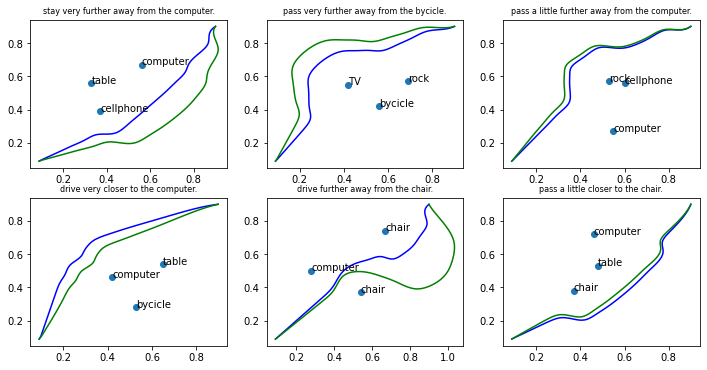

In [5]:
from utils.functions import *
import random

show_data(random.choices(data,k=6))

In [6]:
# for i,d in enumerate(data):
#     d["token_obj_name"] , d["token_clip_text"], d['similarity'] = motion_refiner.compute_clip_similarity(d["obj_names"],[d["text"]])
#     if i % 1000 == 0:
#         print("-------------------------")
#         print(d["text"])
#         # print(d["obj_names"][np.argmax(d["similarity"])])
#         print(d["obj_names"])
#         print(d['similarity'])

In [7]:
total, score = 0, 0
print_fail = False
for d in data:
    #evaluate object matching
    obj = d["obj_in_text"]
    if obj != "":
        if d["obj_names"][np.argmax(d["similarity"])] == obj:
            score+=1
        elif print_fail:
            print("-----------FAIL---------")
            print(d["text"])
            print(re.split("\s|(?<!\d)[,.](?!\d)",d["text"]))
            print(d["obj_names"][np.argmax(d["similarity"])])
            print(d["obj_names"])
            print(d['similarity'])
        total += 1
print("acc: ",score/total)

acc:  0.9967229902713773


## Simple NN head

In [8]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)
from keras import backend as K
from keras.models import Sequential
from keras import Model
from keras.layers import BatchNormalization, Embedding,Flatten, Layer,Dense,Dropout,MultiHeadAttention, Attention, Conv1D ,Input,Lambda, Concatenate,LayerNormalization
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 

tf.random.set_seed(42)

# Split the data: 70% train 20% test 10% validation
n_samples, input_size = X.shape # 768+traj_n*2+max_num_objs*3
X_train_, X_test, y_train_, y_test, indices_train_, indices_test= train_test_split(X, Y,np.arange(n_samples), test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid, indices_train, indices_val = train_test_split(X_train_, y_train_, indices_train_ ,test_size=0.125, shuffle= False)
print("Train X:",X_train.shape,"\tY:",y_train.shape)
print("Test  X:",X_test.shape,"\tY:",y_test.shape)
print("Val   X:",X_valid.shape,"\tY:",y_valid.shape)



['/device:CPU:0', '/device:GPU:0']
Train X: (7223, 797) 	Y: (7223, 20)
Test  X: (2064, 797) 	Y: (2064, 20)
Val   X: (1032, 797) 	Y: (1032, 20)


In [23]:
H = []
best_model = ""
min_val_loss = 100.0
models = {}
models_path = "models/fullyconn2/"
if not os.path.exists(models_path):
    os.makedirs(models_path)
traj_n = 10
for atv in ['tanh']:
    for bs in [128]:
        for ls in [7]:
            for dp in [0.4]:
                for nh in [512]:
                    # try:
                        # define the keras model
                        model = Sequential()
                        model.add(Dense(nh*2, input_dim=input_size, activation='relu'))
                        model.add(Dropout(dp))
                        for i in range(ls):
                            model.add(Dense(nh, activation='relu'))
                            model.add(Dropout(dp))
                        model.add(Dense(traj_n*2, activation=atv))

                        # tf.keras.layers.MultiHeadAttention

                        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)
                        net_name = "fullyconn_bs"+str(bs)+"_atv"+str(atv)+"_ls"+str(ls)+"_dp"+str(dp)+"_nh"+str(nh)+".h5"
                        checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(models_path+net_name, save_format="tf",monitor='val_loss', mode='min', save_best_only=True)

                        loss = tf.keras.losses.MeanSquaredError()
                        # opt = tf.keras.optimizers.Adam(learning_rate=0.05)
                        model.compile(loss=loss, optimizer="adam")
                        # TRAIN
                        history = model.fit(X_train, y_train, epochs=2000, batch_size=bs, callbacks=[callback, checkpoint_cb], validation_split=0.3,verbose=0)
                        H.append(history)
                        # EVALUATION
                        result = model.evaluate(X_test, y_test)
                        best_index = np.argmin(history.history['val_loss'])
                        val_loss = history.history['val_loss'][best_index]
                        print(net_name, '\t MSE ==>  test :', result, "\t val : ",val_loss, "\t train : ",history.history['loss'][best_index])
                        models[net_name] = {"test_loss":result,"val_loss":val_loss,"loss":history.history['loss'][best_index]}
                        print("--------------------------------")

                        if val_loss<min_val_loss:
                            min_val_loss = val_loss
                            best_model = net_name
                    # except:
                    #     pass

65/65 [==============================] - 0s 1ms/step - loss: 0.0069
fullyconn_bs128_atvtanh_ls7_dp0.4_nh512.h5 	 MSE ==>  test : 0.006907973438501358 	 val :  0.0055257398635149 	 train :  0.007836433127522469
--------------------------------


In [10]:

min_test_loss = 10.0
best_model = ""
test_loss = 10.0
names_list = []
test_loss_list = []
for i,m in models.items():
    test_loss = m["test_loss"]
    test_loss_list.append(test_loss)
    names_list.append((i,test_loss))

    if test_loss<min_test_loss:
        min_test_loss = test_loss
        best_model = i
print(best_model, min_test_loss)

def get_test_loss(x):
    return x[1]
names_list.sort(key=get_test_loss)
# print(names_list)
model = tf.keras.models.load_model(models_path+best_model)
result = model.evaluate(X_test, y_test)


fullyconn_bs128_atvtanh_ls5_dp0.1_nh256.h5 0.0047065154649317265
65/65 [==============================] - 0s 1ms/step - loss: 0.0043


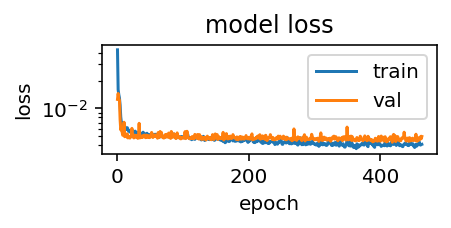

In [11]:
plot_loss(history)

[1436 1989 1394  213 1859 1381]
1/1 [==============================] - 0s 14ms/step - loss: 0.0093
test loss:  0.009282989427447319
MSE samples:  0.009282989111832944


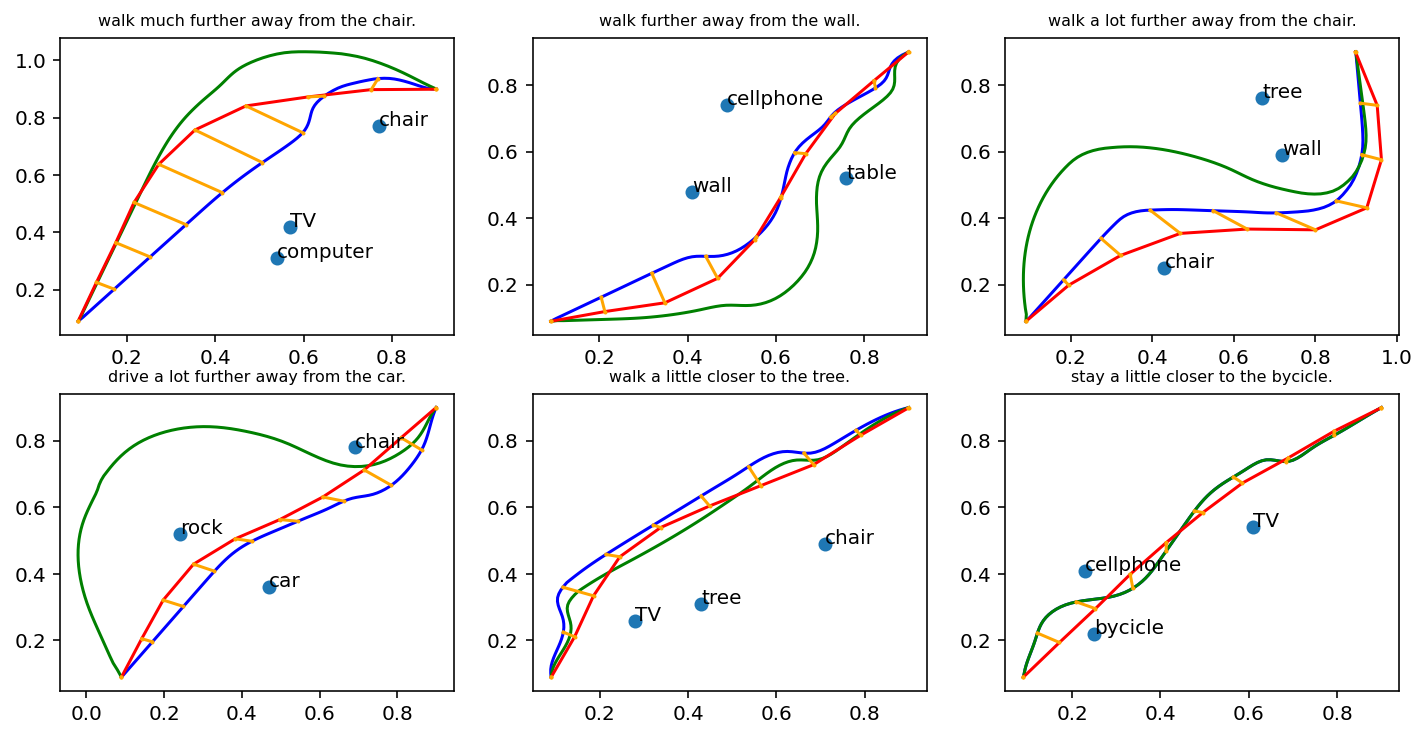

In [14]:
indices = np.random.choice(range(len(indices_test)), 6)

print(indices)

pred = model.predict(X_test)

result = model.evaluate(X_test[indices], y_test[indices])
print('test loss: ', result)
print('MSE samples: ', np.average((pred[indices]-y_test[indices])**2))

data_array = np.array(data)[indices_test[indices]]
show_data(data_array, pred = pred[indices],abs_pred=True)

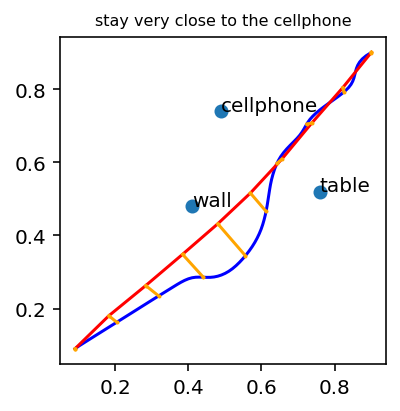

In [29]:
def apply_interaction(model, d,text):
    data_new  = []
    data_new.append({"input_traj":d["input_traj"],"output_traj":d["output_traj"],"text":text,"obj_names":d["obj_names"],
                    "obj_poses":d["obj_poses"]})

    x, _ = motion_refiner.prepare_data(data_new)
    pred_new = model.predict(x)
    show_data(data_new, pred = pred_new, abs_pred=True, show_label=False)

index = 1989
text = "stay very close to the cellphone"
d = np.array(data)[indices_test[index]]
apply_interaction(model,d, text)


# Self attention head

In [ ]:
in_l =Input(shape=input_size)
# l = Attention(use_scale=True, dropout=0.1)([in_l,in_l])
# l = LayerNormalization(epsilon=1e-6)(l)
num_hid = 128
encoder = CrossModalEmbedding(num_hid=num_hid, maxlen=10, num_layers = 2, num_classes=10000, num_heads = 2, features_n = 768, num_feed_forward = 256, source_maxlen=797)

l = encoder(in_l)
print(l.shape)
# l = Dense(512, trainable=True, activation='relu')(in_l)
# l = Dropout(0.1)(l)
# l = Dense(512, trainable=True, activation='relu')(l)
# l = Dropout(0.1)(l)
# l = Dense(256, trainable=True, activation='relu')(l)
# l = Dropout(0.1)(l)
# l = Dense(256, trainable=True, activation='relu')(l)
# l = Concatenate(axis=1)([l, in_l])
# l2 = LayerNormalization(epsilon=1e-6)(l)
# l = Dropout(0.1)(l2)
# l = Dense(256, trainable=True, activation='relu')(l)
# l = Dropout(0.1)(l)
# l = Dense(256, trainable=True, activation='relu')(l)
# l = Concatenate(axis=1)([l, l2])
# l = LayerNormalization(epsilon=1e-6)(l)
l = Flatten()(l)
l = Dense(256, trainable=True, activation='relu')(l)
l = Dropout(0.1)(l)
outputs = Dense(traj_n*2, trainable=True, activation='tanh')(l)
model=Model(in_l,outputs)


earlly_stop_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',  mode='min', verbose=1, patience=30)
# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
logdir = "logs"

tensorboard_cb = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('best_res_model.h5', save_format="tf",monitor='val_loss', mode='min', save_best_only=True)

loss = tf.keras.losses.MeanSquaredError()
opt = tf.keras.optimizers.Adam()

model.compile(loss=loss, optimizer=opt, metrics=[tf.keras.metrics.MeanSquaredError(name='MSE')])

# # TRAIN
history_self_at = model.fit(X_train, y_train, epochs=10, batch_size=128, callbacks=[earlly_stop_cb, tensorboard_cb, checkpoint_cb], validation_data=(X_valid,y_valid),verbose=1)

# EVALUATION
result_self_at = model.evaluate(X_test, y_test)
print('test loss:', result_self_at[0])

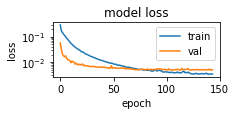

In [ ]:
plot_loss(history_self_at)

[252 149 556 388 940 484]
1/1 [==============================] - 0s 14ms/step - loss: 0.0034 - MSE: 0.0034
test loss:  [0.0034364238381385803, 0.0034364238381385803]
MSE samples:  0.0034364238539963854


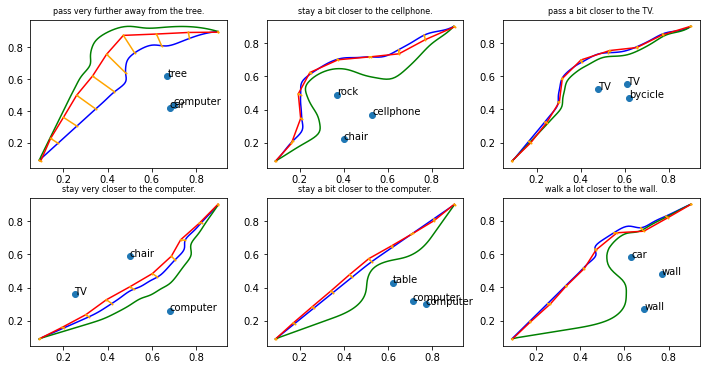

In [ ]:
indices = np.random.choice(range(len(indices_test)), 6)

print(indices)

pred = model.predict(X_test)

result = model.evaluate(X_test[indices], y_test[indices])
print('test loss: ', result)
print('MSE samples: ', np.average((pred[indices]-y_test[indices])**2))

data_array = np.array(data)[indices_test[indices]]
show_data(data_array, pred = pred[indices])

# Transformer head

In [11]:
X.shape

(10319, 797)

In [16]:
class TransformerEncoder(Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, dropout_rate=0.1):
        super().__init__()
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.layernorm3 = LayerNormalization(epsilon=1e-6)
        self.self_att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.enc_att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.self_dropout = Dropout(0.5)
        self.enc_dropout = Dropout(0.1)
        self.ffn_dropout = Dropout(0.1)
        self.ffn = Sequential(
            [
                Dense(feed_forward_dim, activation="relu"),
                Dense(embed_dim),
            ]
        )
    def call(self, enc_out, target):

        target_att = self.self_att(target, target)
        target_norm = self.layernorm1(target + self.self_dropout(target_att))
        enc_out = self.enc_att(target_norm, enc_out)
        enc_out_norm = self.layernorm2(self.enc_dropout(enc_out) + target_norm)
        ffn_out = self.ffn(enc_out_norm)
        ffn_out_norm = self.layernorm3(enc_out_norm + self.ffn_dropout(ffn_out))
        return ffn_out_norm

class TransformerDecoder(Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, dropout_rate=0.1):
        super().__init__()
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.layernorm3 = LayerNormalization(epsilon=1e-6)
        self.self_att = MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.enc_att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.self_dropout = Dropout(0.5)
        self.enc_dropout = Dropout(0.1)
        self.ffn_dropout = Dropout(0.1)
        self.ffn = Sequential(
            [
                Dense(feed_forward_dim, activation="relu"),
                Dense(embed_dim),
            ]
        )

    def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
        """Masks the upper half of the dot product matrix in self attention.

        This prevents flow of information from future tokens to current token.
        1's in the lower triangle, counting from the lower right corner.
        """
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        mask = tf.cast(m, dtype)
        mask = tf.reshape(mask, [1, n_dest, n_src])
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
        )
        return tf.tile(mask, mult)

    def call(self, enc_out, target):
        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = self.causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)

        target_att = self.self_att(target, target, attention_mask=causal_mask)
        # target_att = self.self_att(target, target)


        target_norm = self.layernorm1(target + self.self_dropout(target_att))
        # print("-----------here------------")

        # print(target_norm.shape)
        # print(enc_out.shape)

        enc_out = self.enc_att(target_norm, enc_out)
        # print("-----------DONE------------")
        enc_out_norm = self.layernorm2(self.enc_dropout(enc_out) + target_norm)
        ffn_out = self.ffn(enc_out_norm)
        ffn_out_norm = self.layernorm3(enc_out_norm + self.ffn_dropout(ffn_out))
        return ffn_out_norm


class TrajEmbedding(Layer):
    def __init__(self, num_vocab=1000, maxlen=100, num_hid=64):
        super().__init__()
        self.num_hid = num_hid
        # self.emb = tf.keras.layers.Embedding(10000, num_hid)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=num_hid)
        self.linear_embedding = Dense(num_hid, activation=None, use_bias=False) #only weights multiplication

    def call(self, x):
        maxlen = tf.shape(x)[-2]
        # print(x.shape)
        x = self.linear_embedding(x)
        # print("x == ",x.shape)
        # x = tf.expand_dims(x, 2)

        positions = tf.range(start=0, limit=maxlen, delta=1)

        positions = self.pos_emb(positions)
        # positions = tf.expand_dims(positions, 1)
        # print("pos = ",positions.shape)

        out = x + positions
        # print("traj emb out = ",out.shape)

        return out
class FeatureEmbedding(Layer):
    def __init__(self, num_hid=64, maxlen=100):
        super().__init__()
        # self.conv1 = Conv1D(
        #     num_hid, 11, strides=2, padding="same", activation="relu"
        # )
        # self.conv2 = Conv1D(
        #     num_hid, 11, strides=2, padding="same", activation="relu"
        # )
        # self.conv3 = Conv1D(
        #     num_hid, 11, strides=2, padding="same", activation="relu"
        # )
        self.ff1 = Dense(num_hid*2,activation="relu")
        self.ff2 = Dense(num_hid,activation="relu")

        # self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=num_hid)

    def call(self, x):
        x = self.ff1(x)
        x = self.ff2(x)
        # print("x:",x.shape)
        x = tf.expand_dims(x, axis=1)
        return x


class CrossModalEmbedding(Layer):
    def __init__(self, num_hid=64, maxlen=100, num_classes=20,num_layers = 2, num_heads = 4, features_n = 768, num_feed_forward = 256, source_maxlen=817):
        super().__init__()
        self.enc_traj = TrajEmbedding(num_vocab=num_classes, maxlen=maxlen, num_hid=num_hid)
        self.enc_obj = FeatureEmbedding(num_hid=num_hid)
        self.enc_features = FeatureEmbedding(num_hid=num_hid)
        self.num_layers = num_layers


        self.slice_f = Lambda(lambda x: x[:,:features_n])
        self.slice_obj = Lambda(lambda x: x[:,features_n:-maxlen*2])
        self.slice_traj = Lambda(lambda x: x[:,-maxlen*2:])

        if num_layers>0:
            self.att_f_o = TransformerEncoder(num_hid, num_heads, num_feed_forward)
            self.att_f_t = TransformerEncoder(num_hid, num_heads, num_feed_forward)
            self.att_t_o = TransformerEncoder(num_hid, num_heads, num_feed_forward)
        # self.att_self = MultiHeadAttention(num_heads=num_heads, key_dim=num_hid)
        self.concat = Concatenate(axis=1)
    

    def prepare_y(self,y):
        input_shape = tf.shape(y) 
        # input_shape = y.numpy().shape
        # print(type(input_shape))
        batch_size = input_shape[0]
        seq_len = input_shape[1]

        y= tf.reshape(y,[batch_size,2,tf.dtypes.cast(tf.divide(seq_len,2),tf.int32)])
        y= tf.transpose(y,[0,2,1])

        # y_marker = tf.tile(self.traj_marker, multiples = [batch_size,1,1])
        # print(y_marker.shape)

        # return tf.concat([y,y_marker],axis=2)
        return y

    def call(self, source):
        
        features = self.slice_f(source)
        objs_data = self.slice_obj(source)
        traj = self.slice_traj(source)
        
        traj = self.prepare_y(traj)

        traj = self.enc_traj(traj)
        objs_data = self.enc_obj(objs_data) 
        features = self.enc_features(features)
        # print("enc: ",features.shape, objs_data.shape, traj.shape)

        for i in range(self.num_layers):
            f_o = self.att_f_o(objs_data,features)
            o_f = self.att_f_o(features,objs_data)
            f_t = self.att_f_t(traj,features)
            t_f = self.att_f_t(features,traj)
            o_t = self.att_t_o(traj,objs_data)
            t_o = self.att_t_o(objs_data,traj)

            # print("enc: ",features.shape, objs_data.shape, traj.shape)

            traj = t_f+t_o
            features = f_t+f_o
            objs_data = o_t+o_f
        # print("pos att: ",f_o.shape,f_t.shape,t_o.shape)
        # con = self.concat([traj,objs_data,features])

        con = self.concat([traj,features,objs_data])
        # print("con",con.shape)
        return con

class MultiLinearEmbedding(Layer):
    def __init__(self, num_hid=64):
        super().__init__()

        self.enc_lin1 = Sequential([Dense(num_hid*2, activation='relu'), Dropout(0.1),Dense(num_hid, activation='relu')])
        self.enc_lin2 = Sequential([Dense(num_hid*2, activation='relu'), Dropout(0.1),Dense(num_hid, activation='relu')])
        self.enc_lin3 = Sequential([Dense(num_hid*2, activation='relu'), Dropout(0.1),Dense(num_hid, activation='relu')])
 
    def call(self, source):
        l1 = self.enc_lin1(source)
        l1 = tf.expand_dims(l1, axis=1)
        l2 = self.enc_lin2(source)
        l2 = tf.expand_dims(l2, axis=1)
        l3 = self.enc_lin3(source)

        return l1,l2,l3
        
        
class Transformer(Model):
    def __init__(
        self,
        num_hid=64,
        num_head=2,
        num_feed_forward=128,
        source_maxlen=100,
        target_maxlen=100,
        num_layers_enc=4,
        num_layers_dec=1,
        num_classes=10
    ):
        super().__init__()

        self.loss_metric = tf.keras.metrics.Mean(name="loss")
        self.num_layers_enc = num_layers_enc
        self.num_layers_dec = num_layers_dec
        self.target_maxlen = target_maxlen
        self.num_classes = num_classes
        self.features_n = 768
        self.num_hid = num_hid
        
        self.dec_input = TrajEmbedding(num_vocab=num_classes, maxlen=target_maxlen, num_hid=num_hid)
        # self.encoder = Sequential(
        #     [self.enc_features]
        #     # + [
        #     #     TransformerEncoder(num_hid, num_head, num_feed_forward)
        #     #     for _ in range(num_layers_enc)
        #     # ]
        # )

        self.encoder = CrossModalEmbedding(num_hid=num_hid, maxlen=target_maxlen, num_layers = num_layers_enc, num_classes=num_classes, num_heads = 4, features_n=self.features_n, num_feed_forward = 256, source_maxlen=797)

        # self.encoder = MultiLinearEmbedding(num_hid=num_hid)
        
        for i in range(num_layers_dec):
            setattr(
                self,
                f"dec_layer_{i}",
                TransformerDecoder(num_hid, num_head, num_feed_forward),
            )

        self.slice_traj = Lambda(lambda x: x[:,-maxlen*2:])


        self.classifier = Sequential([
                            Dense(256, activation='relu'),
                            Dropout(0.1),
                            Dense(256, activation='relu'),
                            Dropout(0.1),
                            Dense(2, activation='tanh')])

    def decode(self, enc_out, target,append_enc=False,tokenize=True):
        # y = target
        # print("taget shape: ",target.shape)
        # print("dec: enc_out shape: ",enc_out.shape)

        if tokenize:
            y = self.dec_input(target)
        else:
            y = target
        if append_enc:
            enc_out = tf.concat([enc_out,y],1, name='concat_1')
        
        # print("dec: new enc_out shape: ",enc_out.shape)
        # print("dec: y shape ",y.shape)

        for i in range(self.num_layers_dec):
            y = getattr(self, f"dec_layer_{i}")(enc_out, y)
        return y

    def call(self, inputs):
        source = inputs[0]
        target = inputs[1]
        # print("y: ",y.shape)

        # print("SOURCE call: ",source.shape)
        # print("target call: ",target.shape)

        # l1,l2,l3 = self.encoder(source)
        # # print(l1.shape,l2.shape,l3.shape)

        # y = self.decode(l2, target,append_enc=True)
        # # print("call: y shape: ",y.shape)

        # x = tf.concat([l2,y],1, name='concat_2')
        # # print("call: x shape: ",x.shape)

        # y = self.decode(x, y,tokenize=False)

        # # pre_out = self.pre_classifier(y)
        # # print("out: ",pre_out.shape)
        
        # out = self.classifier(y)

        # # print("x call: ",x.shape)
        # target = self.slice_traj(source)

        # -------- Cross Modal -------- 
        x = self.encoder(source)
        # print("x call: ",x.shape)
        y = self.decode(x, target)
        # y = self.decode(x, x)

        out = self.classifier(y)
        # print("y call: ",y.shape)
        # print("out: ",out.shape)

        return out

    @property
    def metrics(self):
        return [self.loss_metric]

    def train_step(self, batch):
        """Processes one batch inside model.fit()."""

        # print("batch: ",batch.shape)
        if(isinstance(batch, tuple)):
            source = batch[0]
            target = batch[1]
        else:
            source = batch["source"]
            target = batch["target"]
        # target = self.prepare_y(target)
        # print("train SOURCE: ",source.shape)
        dec_input = target[:, :-1,:]
        dec_target = target[:, 1:,:]
        with tf.GradientTape() as tape:
            preds = self([source, dec_input])

            # one_hot = tf.one_hot(dec_target, depth=self.num_classes)
            mask = tf.math.logical_not(tf.math.equal(dec_target, 0))
            # print(mask)

            # print("dec_target: ",dec_target.shape)
            # print("target: ",target.shape)
            # print("preds: ",preds.shape)
            # print("mask:",mask.shape)
            # dec_target = Flatten()(dec_target)
            # preds = Flatten()(preds)
            # mask = Flatten()(mask)

            preds = tf.expand_dims(preds,axis=-1)
            dec_target = tf.expand_dims(dec_target,axis=-1)
            mask = tf.expand_dims(mask,axis=-1)
            
            # dec_target = tf.expand_dims(dec_target,axis=-1)
            # preds = tf.expand_dims(preds,axis=-1)

            loss = self.compiled_loss(dec_target, preds)#, sample_weight=mask)

        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result()}

    def test_step(self, batch):
        if(isinstance(batch, tuple)):
            source = batch[0]
            target = batch[1]
        else:
            source = batch["source"]
            target = batch["target"]

        # target = self.prepare_y(target)

        dec_input = target[:, :-1,:]
        dec_target = target[:, 1:,:]
        preds = self([source, dec_input])
        # one_hot = tf.one_hot(dec_target, depth=self.num_classes)
        mask = tf.math.logical_not(tf.math.equal(dec_target, 0))
        # dec_target = tf.expand_dims(dec_target,axis=-1)

        preds = tf.expand_dims(preds,axis=-1)
        dec_target = tf.expand_dims(dec_target,axis=-1)
        mask = tf.expand_dims(mask,axis=-1)


        # dec_target = Flatten()(dec_target)
        # preds = Flatten()(preds)
        # mask = Flatten()(mask)

        loss = self.compiled_loss(dec_target , preds)#, sample_weight=mask)
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result()}

    def generate(self, source, target_start_token_idx):
        """Performs inference over one batch of inputs using greedy decoding."""
        bs = tf.shape(source)[0]
        enc = self.encoder(source)
        init_input = tf.ones((bs, 1,1)) * target_start_token_idx
        
        dec_input = tf.concat([tf.zeros((bs,1,2)),init_input] ,axis = 2)
        print("Generate dec_input:",dec_input.shape)
        # print("enc:",enc.shape)


        dec_logits = []
        for i in range(self.target_maxlen - 1):
            dec_out = self.decode(enc, dec_input)
            pred = self.classifier(dec_out)

            last_logit = pred[:, -1,:]
            last_logit = tf.expand_dims(last_logit,axis=1)

            dec_input = tf.concat([dec_input, last_logit], axis=1)
        return dec_input

# def create_tf_dataset(x,y, bs=4):

#     ds = tf.data.Dataset.from_tensor_slices((x,y))

#     # ds = tf.data.Dataset.zip((x_d, y_d))
#     ds = ds.map(lambda x, y: {"source": x, "target": y})
#     ds = ds.batch(bs)
#     ds = ds.prefetch(tf.data.AUTOTUNE)
#     return ds
# ds = create_tf_dataset(X_train, y_train, bs=64)

# val_ds = create_tf_dataset(test_data, bs=4)
def prepare_y(y):
    y = np.transpose(y.reshape([y.shape[0],2,int(y.shape[1]/2)]),[0,2,1])
    # y_marker = np.zeros([y_.shape[0],y_.shape[1],1])
    # y_marker[:,0,0] = -0.5  #begining of the traj
    # y_marker[:,-1,0] = 0.5 #end of traj
    # return np.concatenate((y_,y_marker),axis=2) 
    return y
    
model = Transformer(
    num_hid=200,
    num_head=8,
    num_feed_forward=512,
    target_maxlen=traj_n,
    source_maxlen=input_size,
    num_layers_enc=0,
    num_layers_dec=1,
    num_classes=traj_n,
)


# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
logdir = "logs"

import shutil
try:
    shutil.rmtree(logdir)
except OSError as e:
    print("Error: %s - %s." % (e.filename, e.strerror))


earlly_stop_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',  mode='min', verbose=2, patience=10)
tensorboard_cb = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
# checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('best_self_att_model2.h5', save_format="tf",monitor='val_loss', mode='min', save_best_only=True)

loss = tf.keras.losses.MeanSquaredError()
opt = tf.keras.optimizers.Adam()
# opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss=loss, optimizer=opt, metrics=[tf.keras.metrics.MeanSquaredError(name='MSE')])

# # TRAIN
# history = model.fit(ds, epochs=15, batch_size=3000, callbacks=[callback],verbose=1)
history = model.fit(X_train, prepare_y(y_train), epochs=50, batch_size=128, callbacks=[earlly_stop_cb, tensorboard_cb], validation_data=(X_valid, prepare_y(y_valid)),verbose=1)
model.save('best_cross_att_model2',save_format='tf')

# EVALUATION
result_self_at = model.evaluate(X_test, prepare_y(y_test))
print('test loss:', result_self_at)


Error: logs - No such file or directory.
Epoch 1/50
57/57 [==============================] - 4s 31ms/step - loss: 0.0430 - val_loss: 0.0022
Epoch 2/50
57/57 [==============================] - 1s 17ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 3/50
57/57 [==============================] - 1s 16ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 4/50
57/57 [==============================] - 1s 17ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 5/50
57/57 [==============================] - 1s 18ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 6/50
57/57 [==============================] - 1s 19ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 7/50
57/57 [==============================] - 1s 17ms/step - loss: 0.0012 - val_loss: 9.1137e-04
Epoch 8/50
57/57 [==============================] - 1s 18ms/step - loss: 0.0010 - val_loss: 9.5148e-04
Epoch 9/50
57/57 [==============================] - 1s 17ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 10/50
57/57 [==============================] - 1s 18ms

65/65 [==============================] - 0s 4ms/step - loss: 4.1516e-04
test loss: 0.0004151597386226058


In [ ]:
model.summary()

In [ ]:
history = model.fit(X_train, prepare_y(y_train), epochs=20, batch_size=128, callbacks=[earlly_stop_cb, tensorboard_cb], validation_data=(X_valid, prepare_y(y_valid)),verbose=1)
model.save('best_cross_att_model2',save_format='tf')

In [9]:
print(np.average((prepare_y(y_test)[:,1:,:]-prepare_y(y_test)[:,:-1,:])**2))

0.01040996685169217


226/226 [==============================] - 1s 4ms/step - loss: 4.4999e-04
train loss: 0.00044998855446465313
65/65 [==============================] - 0s 4ms/step - loss: 4.1516e-04
test loss: 0.0004151597386226058


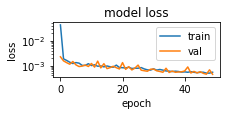

In [17]:
# # EVALUATION
result_self_at = model.evaluate(X_train, prepare_y(y_train))
print('train loss:', result_self_at)
result_self_at = model.evaluate(X_test,  prepare_y(y_test))
print('test loss:', result_self_at)

plot_loss(history)

In [ ]:
indices = np.random.choice(range(len(indices_test)), 6)

# indices = [0,1,2,3,4,5,6]

Generate dec_input: (2064, 1, 2)
0.005007297944766405


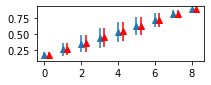

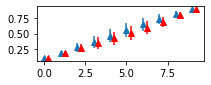

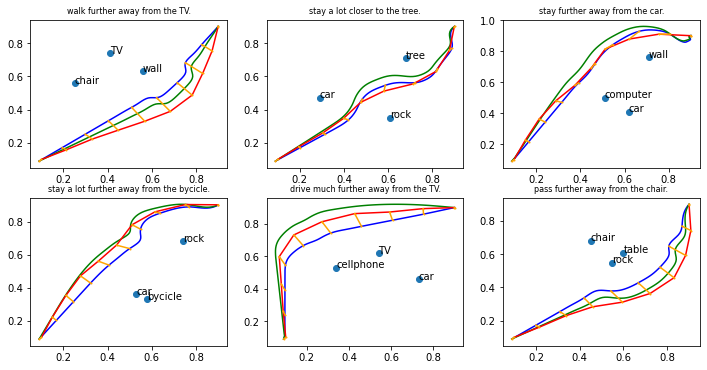

In [19]:
indices = np.random.choice(range(len(indices_test)), 6)

def generate(model, source, target_start_token_idx,y=None):
    """Performs inference over one batch of inputs using greedy decoding."""
    bs = tf.shape(source)[0]
    enc = model.encoder(source)
    init_input = tf.ones((bs, 1,2)) * target_start_token_idx
    # dec_input = tf.concat([tf.zeros((bs,1,2)),init_input] ,axis = 2)
    dec_input = init_input
    print("Generate dec_input:",dec_input.shape)
    # print(dec_input)
    
    # dec_input = prepare_y(y_test)[:,:,:]
    # print("enc:",enc.shape)

    # for i in range(model.target_maxlen - 1):
    #     dec_out = model.decode(enc, dec_input)
    #     pred = model.classifier(dec_out)
    #     # dec_input [:,i+1,:] = pred[:,i,:]


    #     last_logit = pred[:, -1,:]
    #     last_logit = tf.expand_dims(last_logit,axis=1)
    #     dec_input = tf.concat([dec_input[:,:i+1,:], pred[:,i:i+1,:],dec_input[:,i+2:,:]], axis=1)
    #     # print(np.average((y[:,i:i+2,:2]-dec_input[:,i:,:2])**2))
    # return dec_input

    for i in range(model.target_maxlen - 1):
        dec_out = model.decode(enc, dec_input)
        pred = model.classifier(dec_out)

        last_logit = pred[:, -1,:]
        # print(last_logit[0, :])
        last_logit = tf.expand_dims(last_logit,axis=1)
        dec_input = tf.concat([dec_input, last_logit], axis=1)
        # print(np.average((y[:,i:i+2,:2]-dec_input[:,i:,:2])**2))
    return dec_input



pred = generate(model,X_test,0.1,y=prepare_y(y_test)).numpy()
# model(X_test,y_test)
target = prepare_y(y_test)[:,1:,:]
# model(X_test)
print(np.average((target - pred[:,1:,:])**2))
# print(pred)

pred = np.transpose(pred[:,:,:2],[0,2,1])
def plot_dist(x):
    plt.figure(figsize=(3,1))
    avr = np.average(x,(0))
    e = np.std(x,(0))
    plt.errorbar(np.arange(len(avr[0,:])), avr[0,:], e[0,:], linestyle='None', marker='^')
    plt.errorbar(np.arange(len(avr[1,:]))+0.25, avr[1,:], e[1,:], linestyle='None', marker='^',color="red")

    plt.show()
plot_dist(np.transpose(target[:,:,:2],[0,2,1]))
plot_dist(pred)

pred = pred.reshape([pred.shape[0],pred.shape[2]*2])
# print(pred[indices])

data_array = np.array(data)[indices_test[indices]]
# print(pred)
show_data(data_array, pred = pred[indices], abs_pred=True)

In [20]:
print(np.average(y_test**2))
print(np.average(pred**2))
print(np.average((y_test-pred)**2))
print(np.average((y_test[:,0])**2))


0.3264705458389824
0.31510192
0.004516568153269997
0.0081


In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model,show_shapes=True, show_layer_names=True) 

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [ ]:
def plot_att_matrix(model):
    #plot attention matrix
    pass
plot_att_matrix(model)

# Transformer decoder